# Transfer Learning with TensorFlow : Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

See full course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/

In [2]:
# Check if we're using GPU
!nvidia-smi

Fri Jan 20 09:59:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Frameworks for model build
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
# Frameworks for supporting model
import os 
import pathlib
import zipfile
import datetime
import random

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [6]:
!wget https://github.com/Shakhthi/Deep-Learning/blob/main/TensorFlow%20Certificate:%202023/extras/helper_functions.py

--2023-01-20 09:59:54--  https://github.com/Shakhthi/Deep-Learning/blob/main/TensorFlow%20Certificate:%202023/extras/helper_functions.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘helper_functions.py’

helper_functions.py     [ <=>                ] 267.38K  --.-KB/s    in 0.02s   

2023-01-20 09:59:55 (12.7 MB/s) - ‘helper_functions.py’ saved [273799]



> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-01-20 09:59:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.2MB/s    in 7.9s    

2023-01-20 10:00:03 (20.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [8]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [9]:
for dir_path, dir_name, files in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dir_name)} & {len(files)} in path {dir_path}")

There are 2 & 0 in path 10_food_classes_10_percent
There are 10 & 0 in path 10_food_classes_10_percent/test
There are 0 & 250 in path 10_food_classes_10_percent/test/chicken_curry
There are 0 & 250 in path 10_food_classes_10_percent/test/sushi
There are 0 & 250 in path 10_food_classes_10_percent/test/fried_rice
There are 0 & 250 in path 10_food_classes_10_percent/test/pizza
There are 0 & 250 in path 10_food_classes_10_percent/test/grilled_salmon
There are 0 & 250 in path 10_food_classes_10_percent/test/hamburger
There are 0 & 250 in path 10_food_classes_10_percent/test/ramen
There are 0 & 250 in path 10_food_classes_10_percent/test/steak
There are 0 & 250 in path 10_food_classes_10_percent/test/chicken_wings
There are 0 & 250 in path 10_food_classes_10_percent/test/ice_cream
There are 10 & 0 in path 10_food_classes_10_percent/train
There are 0 & 75 in path 10_food_classes_10_percent/train/chicken_curry
There are 0 & 75 in path 10_food_classes_10_percent/train/sushi
There are 0 & 75 in 

In [10]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [11]:

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SHAPE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE
                                                                 )

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SHAPE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [12]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [13]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [14]:
# See an example of batch data
for images, labels in train_data.take(1):
  print(images, labels)

tf.Tensor(
[[[[254.         254.         254.        ]
   [254.         254.         254.        ]
   [254.         254.         254.        ]
   ...
   [158.648      188.86226    222.21947   ]
   [158.         188.         222.        ]
   [156.35718    189.35718    222.35718   ]]

  [[254.         254.         254.        ]
   [254.         254.         254.        ]
   [254.         254.         254.        ]
   ...
   [158.85716    189.07143    222.42863   ]
   [156.93365    189.93365    222.93365   ]
   [157.02551    190.02551    223.02551   ]]

  [[254.         254.         254.        ]
   [254.         254.         254.        ]
   [254.         254.         254.        ]
   ...
   [158.55101    190.61737    223.35721   ]
   [157.72958    190.72958    223.72958   ]
   [157.86226    190.86226    225.43369   ]]

  ...

  [[105.581635   131.58163    148.58163   ]
   [108.84184    133.84184    153.84184   ]
   [113.78571    139.21428    159.42857   ]
   ...
   [  5.1683483    6.168

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [15]:
# create a TensorBoard callback (functionized because we need one for each model)
def tensorboard_callback(dir_name, experiment_name):
  
  logs_directory = dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
  
  TensorBoard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_directory)
  print(f"Saving TensorBoard logfiles to: {logs_directory}")
  
  return TensorBoard_callback


In [16]:

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

x = base_model(inputs)
print(f" shape after inputs through our model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"shape after pooling: {x.shape}")

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile( loss="categorical_crossentropy",
                 optimizer = "Adam",
                 metrics = ["accuracy"])

meta_0 = model_0.fit(train_data,
                     epochs = 5,
                     steps_per_epoch = len(train_data),
                     validation_data = test_data,
                     validation_steps = len(test_data),
                     callbacks = [tensorboard_callback("transfer_learning", "Base_model")]
                     )


16705208/16705208 [==============================] - 2s 0us/step
 shape after inputs through our model: (None, 7, 7, 1280)
shape after pooling: (None, 1280)
Saving TensorBoard logfiles to: transfer_learning/Base_model/20012023-100013
Epoch 1/5
24/24 [==============================] - 22s 404ms/step - loss: 1.8625 - accuracy: 0.4507 - val_loss: 1.2913 - val_accuracy: 0.7436
Epoch 2/5
24/24 [==============================] - 8s 316ms/step - loss: 1.0958 - accuracy: 0.7467 - val_loss: 0.8574 - val_accuracy: 0.8316
Epoch 3/5
24/24 [==============================] - 8s 315ms/step - loss: 0.7925 - accuracy: 0.8227 - val_loss: 0.6902 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 8s 319ms/step - loss: 0.6354 - accuracy: 0.8493 - val_loss: 0.6012 - val_accuracy: 0.8640
Epoch 5/5
24/24 [==============================] - 8s 317ms/step - loss: 0.5501 - accuracy: 0.8720 - val_loss: 0.5478 - val_accuracy: 0.8684


In [17]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.5478 - accuracy: 0.8684


[0.5477771759033203, 0.868399977684021]

In [18]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, end="\n") 

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [19]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [20]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [21]:
# Plot the validation and training curves separately
def plot_loss_curve(meta):

  fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

  loss = meta.history["loss"]
  accuracy = meta.history["accuracy"]

  val_loss = meta.history["val_loss"]
  val_accuracy = meta.history["val_accuracy"]

  epochs = range(len(meta.history["loss"]))

  sns.lineplot(data=meta.history, y=loss, x=epochs, label="loss", ax=ax1)
  sns.lineplot(data=meta.history, y=val_loss, x=epochs, label="val_loss", ax=ax1).set(title="Loss Curve", xlabel="epochs")
  ax1.grid(False)
  ax1.legend(loc="upper right");
 

  sns.lineplot(x=epochs, y=accuracy, label="accuracy", ax=ax2)
  sns.lineplot(x=epochs, y=val_accuracy, label="val_accuracy", ax=ax2).set(title="Accuracy Curve", xlabel="epochs")
  ax2.grid(False)
  ax2.legend(loc="lower right");


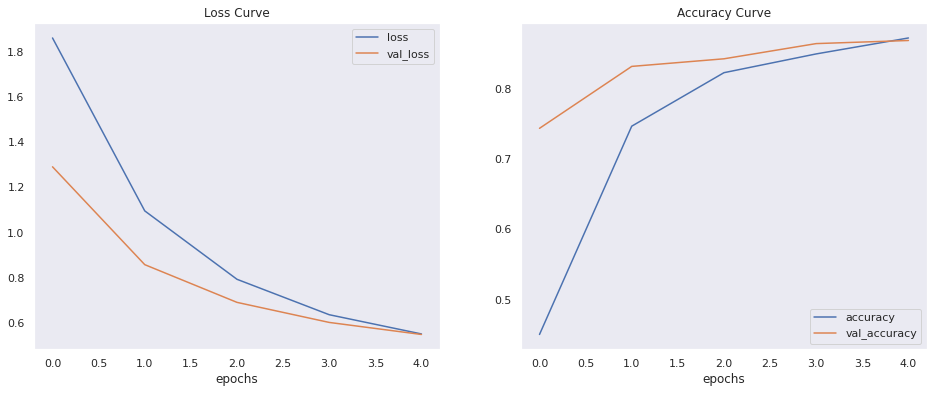

In [22]:
plot_loss_curve(meta_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [23]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [24]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> 🛠 **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of for our own specifc problem.

In [25]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global max Pooled 2D tensor: {global_max_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global max pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global max Pooled 2D tensor: (1, 3)


## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation 
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentaton 
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation 

> 🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [26]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip 

zip_ref = zipfile.ZipFile("10_food_classes_1_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-01-20 10:01:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  21.1MB/s    in 7.3s    

2023-01-20 10:01:38 (17.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [27]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [28]:
# How many images are we working with?
for dir_path, dir_name, files in os.walk("10_food_classes_1_percent"):
  print(f"There are {len(dir_name)} & {len(files)} in path {dir_path}")

There are 2 & 0 in path 10_food_classes_1_percent
There are 10 & 0 in path 10_food_classes_1_percent/test
There are 0 & 250 in path 10_food_classes_1_percent/test/chicken_curry
There are 0 & 250 in path 10_food_classes_1_percent/test/sushi
There are 0 & 250 in path 10_food_classes_1_percent/test/fried_rice
There are 0 & 250 in path 10_food_classes_1_percent/test/pizza
There are 0 & 250 in path 10_food_classes_1_percent/test/grilled_salmon
There are 0 & 250 in path 10_food_classes_1_percent/test/hamburger
There are 0 & 250 in path 10_food_classes_1_percent/test/ramen
There are 0 & 250 in path 10_food_classes_1_percent/test/steak
There are 0 & 250 in path 10_food_classes_1_percent/test/chicken_wings
There are 0 & 250 in path 10_food_classes_1_percent/test/ice_cream
There are 10 & 0 in path 10_food_classes_1_percent/train
There are 0 & 7 in path 10_food_classes_1_percent/train/chicken_curry
There are 0 & 7 in path 10_food_classes_1_percent/train/sushi
There are 0 & 7 in path 10_food_class

In [29]:
# Setup data loaders 
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers 

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of imges (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Iamge data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [30]:
from tensorflow.keras.layers.experimental import preprocessing

In [31]:
# Augmentation layer
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.2),
        preprocessing.RandomHeight(0.2),
        preprocessing.RandomWidth(0.2)
    ], name="Data_augmentation_layer"
)

### Visualize our data augmentation layer (and see what happens to our data)

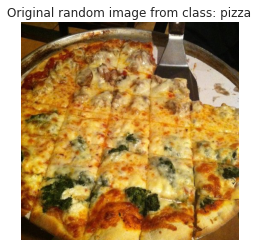

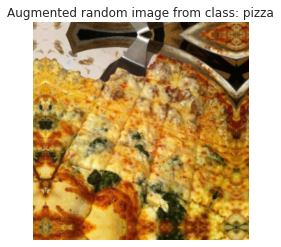

In [32]:
# View random image to compare it to augmented image
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);
# print(augmented_img)


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [33]:
# setup input shape, base model & freeze the base model layers
IMG_SIZE = (224,224,3)
BATCH_SIZE = 32
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create input layer
inputs = tf.keras.layers.Input(shape=IMG_SIZE, name="input_layer")

# Add in data augmentation sequential model as base model's layer
x = data_augmentation(inputs)

# Give base model the inputs & dont train it
x = base_model(x, training=False)

# pool out features of the model
x = tf.keras.layers.GlobalAveragePooling2D(name="Average_Pooling_layer")(x)

# put a dense layer as the output layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using inputs & outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

# Fit the model
meta_1 = model_1.fit(train_data_1_percent,
                     epochs = 5,
                     steps_per_epoch = len(train_data_1_percent),
                     validation_data = test_data,
                     validation_steps = int((0.25 * len(test_data))),
                     callbacks = [tensorboard_callback(dir_name="transfer_learning",
                                                       experiment_name="1_percent_data_augmentation")])

Saving TensorBoard logfiles to: transfer_learning/1_percent_data_augmentation/20012023-100142
Epoch 1/5
3/3 [==============================] - 14s 4s/step - loss: 2.4093 - accuracy: 0.1429 - val_loss: 2.2459 - val_accuracy: 0.1628
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1813 - accuracy: 0.2714 - val_loss: 2.0896 - val_accuracy: 0.2632
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9849 - accuracy: 0.3857 - val_loss: 1.9746 - val_accuracy: 0.3569
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7693 - accuracy: 0.4857 - val_loss: 1.8732 - val_accuracy: 0.4342
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5809 - accuracy: 0.6714 - val_loss: 1.8030 - val_accuracy: 0.4885


In [34]:
# Evaluate on the full dataset
model_1.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 1.7817 - accuracy: 0.4920


[1.7817082405090332, 0.492000013589859]

In [35]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_augmentation_layer (Se  (None, None, None, 3)    0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Average_Pooling_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

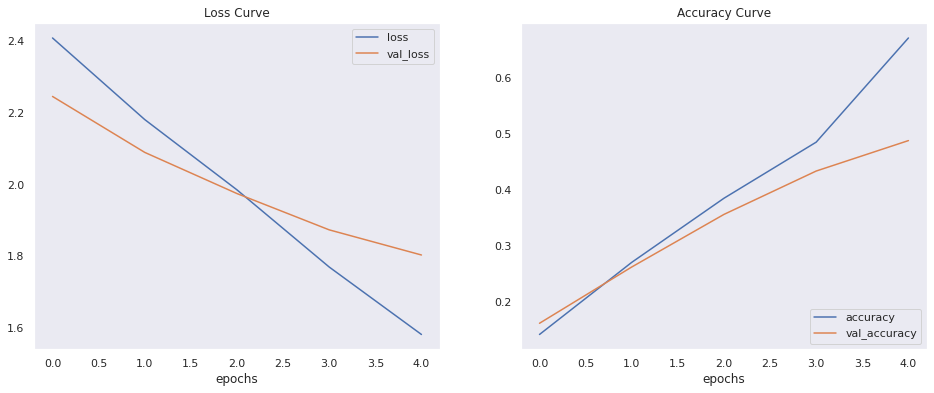

In [36]:
plot_loss_curve(meta_1)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [37]:
# Get 10% of data... (uncomment if you don't have it)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data(10_food_classes_10_percent)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [38]:
for dir_path, dir_name, files in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dir_name)} & {len(files)} in path {dir_path}")

There are 2 & 0 in path 10_food_classes_10_percent
There are 10 & 0 in path 10_food_classes_10_percent/test
There are 0 & 250 in path 10_food_classes_10_percent/test/chicken_curry
There are 0 & 250 in path 10_food_classes_10_percent/test/sushi
There are 0 & 250 in path 10_food_classes_10_percent/test/fried_rice
There are 0 & 250 in path 10_food_classes_10_percent/test/pizza
There are 0 & 250 in path 10_food_classes_10_percent/test/grilled_salmon
There are 0 & 250 in path 10_food_classes_10_percent/test/hamburger
There are 0 & 250 in path 10_food_classes_10_percent/test/ramen
There are 0 & 250 in path 10_food_classes_10_percent/test/steak
There are 0 & 250 in path 10_food_classes_10_percent/test/chicken_wings
There are 0 & 250 in path 10_food_classes_10_percent/test/ice_cream
There are 10 & 0 in path 10_food_classes_10_percent/train
There are 0 & 75 in path 10_food_classes_10_percent/train/chicken_curry
There are 0 & 75 in path 10_food_classes_10_percent/train/sushi
There are 0 & 75 in 

In [39]:
# set up dataset
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            image_size=(224,224),
                                                                            label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               image_size=(224,224),
                                                               label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [40]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # if you're using a model such as ResNet50V2, you'll need to rescale your data, efficientnet has rescaling built-in
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated - https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [41]:
# setup model checkpoint path
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoints.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                   save_weights_only = True,
                                   save_best_only = True,
                                   save_freq = "epoch",
                                   verbose = 1)

### Fit model 2 passing in the ModelCheckpoint callback

In [42]:
meta_10_percent_data_augmentation = model_2.fit(train_data_10_percent,
                                                epochs = 5,
                                                steps_per_epoch = len(train_data_10_percent),
                                                validation_data = test_data,
                                                validation_steps = int(0.25 * len(test_data)),
                                                callbacks = [tensorboard_callback("transfer_learning", "10_percent_data_augmentation"),
                                                             checkpoint_callback])

Saving TensorBoard logfiles to: transfer_learning/10_percent_data_augmentation/20012023-100225
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9596 - accuracy: 0.3720
Epoch 1: val_loss improved from inf to 1.40804, saving model to 10_percent_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 19s 546ms/step - loss: 1.9596 - accuracy: 0.3720 - val_loss: 1.4080 - val_accuracy: 0.6924
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2912 - accuracy: 0.7133
Epoch 2: val_loss improved from 1.40804 to 0.98041, saving model to 10_percent_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 11s 451ms/step - loss: 1.2912 - accuracy: 0.7133 - val_loss: 0.9804 - val_accuracy: 0.7878
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9777 - accuracy: 0.7667
Epoch 3: val_loss improved from 0.98041 to 0.79288, saving model to 10_percent_model_checkpoints_weights/checkpoints.ckpt


In [43]:
results_model_2 = model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6200 - accuracy: 0.8392


In [44]:
# what are the model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 9s 89ms/step - loss: 0.5478 - accuracy: 0.8684


[0.5477770566940308, 0.868399977684021]

In [45]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

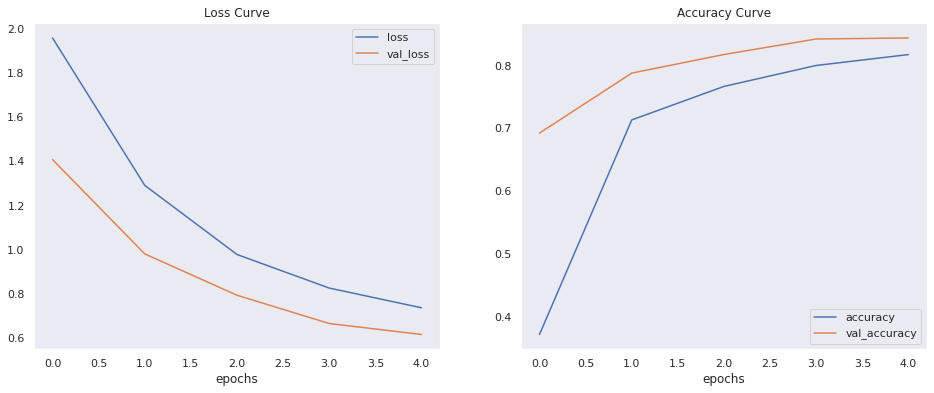

In [46]:
plot_loss_curve(meta_10_percent_data_augmentation)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [47]:
# Load in saved model weights & evaluate model
model_2.load_weights(checkpoint_path)

In [48]:
results_model_2_loaded_weighs = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.6200 - accuracy: 0.8392


In [49]:
# Compare actual model & model with loaded weights
results_model_2_loaded_weighs == results_model_2

False

In [50]:
results_model_2_loaded_weighs

[0.6199755668640137, 0.8392000198364258]

In [51]:
results_model_2

[0.6199755072593689, 0.8392000198364258]

In [52]:
np.isclose(np.array(results_model_2), np.array(results_model_2_loaded_weighs))

array([ True,  True])

## Model 3: Fine-tuning an existing model on 10% of the data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [53]:
# layers in the model
model_2.layers

In [54]:
# are these layers trainable?
for i in model_2.layers:
  print(i, i.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fcf6b83e9d0> True
<keras.engine.sequential.Sequential object at 0x7fcf644fa760> True
<keras.engine.functional.Functional object at 0x7fcf641fbfd0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fcf69ecb610> True
<keras.layers.core.dense.Dense object at 0x7fcf642fb6d0> True


In [55]:
# what are the layers in our base model trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [56]:
# How many trainable varialbes are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [57]:
# To begin with fine-tunning, setup last 10 layers of the base model as trainable
base_model.trainable = True

# Freeze all layers except last 10 layers
for i, layer in enumerate(base_model.layers[:-10]):
  layer.trainable = False

# Compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ["accuracy"])  

> 🔑 **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values). A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146 

In [58]:
# Check which layers are tunable
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [59]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [60]:
# Fine tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
meta_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=meta_10_percent_data_augmentation.epoch[-1], # start training from previous last epoch
                                               callbacks=[tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard logfiles to: transfer_learning/10_percent_fine_tune_last_10/20012023-100422
Epoch 5/10
24/24 [==============================] - 19s 497ms/step - loss: 0.6325 - accuracy: 0.8267 - val_loss: 0.4834 - val_accuracy: 0.8520
Epoch 6/10
24/24 [==============================] - 9s 385ms/step - loss: 0.5002 - accuracy: 0.8587 - val_loss: 0.4594 - val_accuracy: 0.8503
Epoch 7/10
24/24 [==============================] - 8s 327ms/step - loss: 0.4407 - accuracy: 0.8653 - val_loss: 0.4359 - val_accuracy: 0.8569
Epoch 8/10
24/24 [==============================] - 10s 392ms/step - loss: 0.3988 - accuracy: 0.8813 - val_loss: 0.4334 - val_accuracy: 0.8569
Epoch 9/10
24/24 [==============================] - 10s 422ms/step - loss: 0.3474 - accuracy: 0.9000 - val_loss: 0.4170 - val_accuracy: 0.8684
Epoch 10/10
24/24 [==============================] - 8s 323ms/step - loss: 0.3091 - accuracy: 0.9080 - val_loss: 0.4044 - val_accuracy: 0.8569


In [61]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.4171 - accuracy: 0.8552


[0.417146235704422, 0.8551999926567078]

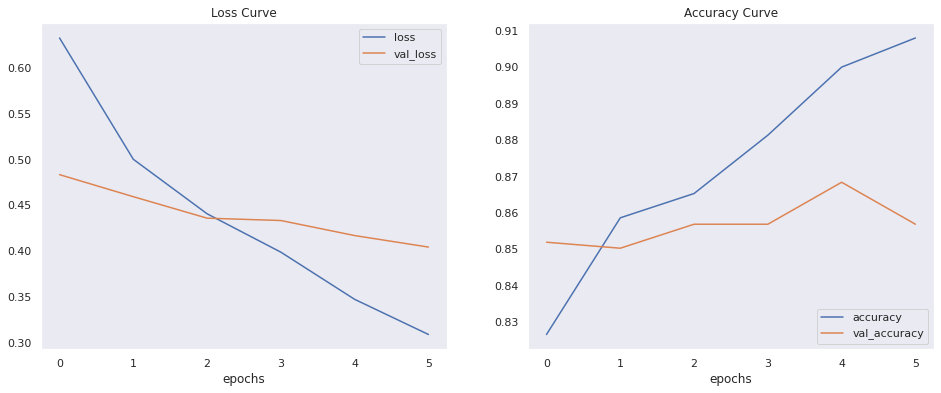

In [62]:
plot_loss_curve(meta_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [66]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

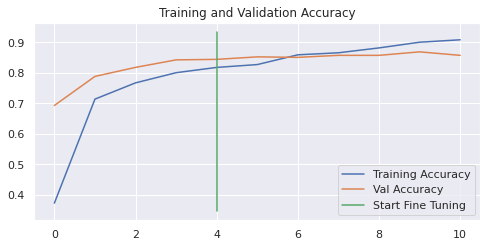

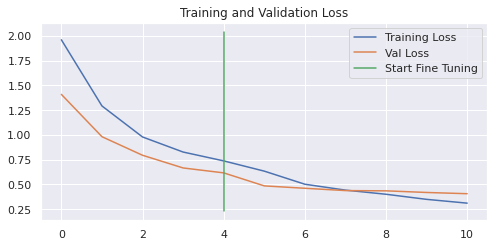

In [67]:
compare_historys(meta_10_percent_data_augmentation, meta_fine_10_percent_data_aug, initial_epochs=5)

In [65]:
def plot_history_comparison(original_history, tunned_history, initial_epochs=5):
  """
  Plots trained model & fine tuned model for comaprison.
  """
  # Original history parameters
  loss = original_history.history["loss"]
  val_loss = original_history.history["loss"]

  accuracy = original_history.history["accuracy"]
  val_accuracy = original_history.history["val_accuracy"]

  plt.subplots(1,2, figsize=(16,6))



## Model 4: Fine-tuning and existing model on all of the data

In [68]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip


--2023-01-20 10:09:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  24.0MB/s    in 22s     

2023-01-20 10:09:57 (22.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [69]:
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [70]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [71]:
# How many images are we working with now?
for dir_path, directories, files in os.walk("10_food_classes_all_data"):
  print(f"There are {len(directories)} & {len(files)} in path {dir_path}")

There are 2 & 0 in path 10_food_classes_all_data
There are 10 & 0 in path 10_food_classes_all_data/test
There are 0 & 250 in path 10_food_classes_all_data/test/chicken_curry
There are 0 & 250 in path 10_food_classes_all_data/test/sushi
There are 0 & 250 in path 10_food_classes_all_data/test/fried_rice
There are 0 & 250 in path 10_food_classes_all_data/test/pizza
There are 0 & 250 in path 10_food_classes_all_data/test/grilled_salmon
There are 0 & 250 in path 10_food_classes_all_data/test/hamburger
There are 0 & 250 in path 10_food_classes_all_data/test/ramen
There are 0 & 250 in path 10_food_classes_all_data/test/steak
There are 0 & 250 in path 10_food_classes_all_data/test/chicken_wings
There are 0 & 250 in path 10_food_classes_all_data/test/ice_cream
There are 10 & 0 in path 10_food_classes_all_data/train
There are 0 & 750 in path 10_food_classes_all_data/train/chicken_curry
There are 0 & 750 in path 10_food_classes_all_data/train/sushi
There are 0 & 750 in path 10_food_classes_all_da

In [72]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [73]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.4171 - accuracy: 0.8552


[0.4171462059020996, 0.8551999926567078]

In [75]:
results_model_2

[0.6199755072593689, 0.8392000198364258]

In [76]:
# Load weights from checkpoint, that way we can fine-tune from 
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [77]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6200 - accuracy: 0.8392


[0.6199755668640137, 0.8392000198364258]

In [78]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_model_2_loaded_weighs

[0.6199755668640137, 0.8392000198364258]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).

In [79]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [80]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [81]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [83]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=meta_10_percent_data_augmentation.epoch[-1],
                                           callbacks=[tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard logfiles to: transfer_learning/full_10_classes_fine_tune_last_10/20012023-102522
Epoch 5/10
235/235 [==============================] - 53s 222ms/step - loss: 0.5333 - accuracy: 0.8301 - val_loss: 0.2933 - val_accuracy: 0.9145
Epoch 6/10
235/235 [==============================] - 50s 210ms/step - loss: 0.4602 - accuracy: 0.8536 - val_loss: 0.3228 - val_accuracy: 0.8947
Epoch 7/10
235/235 [==============================] - 47s 198ms/step - loss: 0.4256 - accuracy: 0.8599 - val_loss: 0.2945 - val_accuracy: 0.9062
Epoch 8/10
235/235 [==============================] - 45s 190ms/step - loss: 0.3960 - accuracy: 0.8709 - val_loss: 0.2594 - val_accuracy: 0.9260
Epoch 9/10
235/235 [==============================] - 43s 180ms/step - loss: 0.3657 - accuracy: 0.8840 - val_loss: 0.2772 - val_accuracy: 0.9227
Epoch 10/10
235/235 [==============================] - 40s 169ms/step - loss: 0.3432 - accuracy: 0.8905 - val_loss: 0.2810 - val_accuracy: 0.9161


> 🔑 **Note:** Fine-tuning generally takes longer per epoch (more layers being updated) and in the case of the model we just ran we used 10x more data than before (more patterns to find) so it makes sense training took longer.

In [84]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 72ms/step - loss: 0.2527 - accuracy: 0.9176


[0.2527262568473816, 0.9175999760627747]

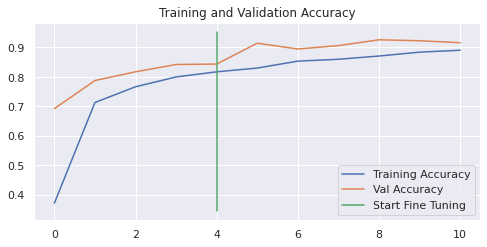

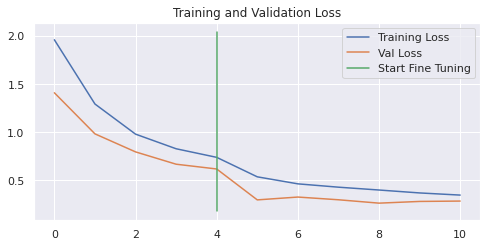

In [85]:
# How did fine-tuning go with more data?
compare_historys(original_history=meta_10_percent_data_augmentation,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

> 🔑 **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once its finished uploading

My TensorBoard experiments are available at: https://tensorboard.dev/experiment/vcySzjmkRkKBLVSdAQMO8g/ 

If you need to view or delete a previous TensorBoard experiment, you can run the commands below.

In [ ]:
# # View all of your uploaded TensorBoard.dev experiments (public)
# !tensorboard dev list

In [ ]:
# # To delete an experiment
# !tensorboard dev delete --experiment_id vcySzjmkRkKBLVSdAQMO8g # Change this for the experiment ID you want to delete